In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random as rd

from irrmc.irrmontecarlo import Asset, Fund, portfolioScaling, portfolioGenerator, portfolioValue, MC, multiMC,plotMC, portfolioMC, meanIRR, IRRMonteCarlo 

path = '/Downloads/market_data_V.xlsx'
xl = pd.ExcelFile(path)

dfs = {sheet_name: xl.parse(sheet_name) 
          for sheet_name in xl.sheet_names}

"dfs = pd.read_excel(file_name, sheet_name=None)"
print(xl.sheet_names)
df1 = xl.parse('Data_Values')
df1 = xl.parse('Data_Values')
xln = np.array(df1)
fe = df1.iloc[6:,0:3]
fe.columns = ['EURUSD', 'GBPUSD','EURGBP']
fe.head(3)
fe.iloc[69,0] = (fe.iloc[68,0] + fe.iloc[70,0])/2
fe.head(5)

eurusd = fe.iloc[:,0]
gbpusd = fe.iloc[:,1]
eurgbp = fe.iloc[:,2]


['Data', 'Tickers', 'Data_Values']


Here we load the market data into a pandas dataframe. We want the spot price for EURUSD, GBPUSD and EURGBP. The reason for the line "fe.iloc[69,0] = (fe.iloc[68,0] + fe.iloc[70,0])/2" was that this data point was in a date format, so I made it equal to the average of the data points either side.

We have eurusd, gbpusd and eurgbp all as pandas series.

**Step 1 - Hypothetical Fund Model**

Now we create a hypothetical fund model including US, GBP and EUR investments. We do this by creating 10 assets, a portfolio (an arry of assets) and a Fund using the Asset and Fund classes within the irrmc.irrmontecarlo package. 

An Asset is of the form Asset(Value, Annual Return, Currency)
Assets have the following attributes:
        self.price = Price
        self.returnyoy = Returnyoy
        self.currency = Currency
        self.daily_return = np.exp(np.log(Returnyoy)/252)

A Fund is of the form Fund(Capital,Portfolio)
Funds have the following attributes:
        self.initialcapital = Capital
        self.portfolio = Portfolio
        self.value =  sum(asset.price for asset in Portfolio)


Here we also create duplicates of the 10 assets and portfolio as due to the mutability of python objects and custom classes, we need a portfolio to represent the initial state of the fund when comparing our monte carlo simulation results.


Note: All prices are in millions (USD). So Fund(10,portfolio_init) has 10 million USD. 

In [2]:
us1 = Asset(20, 1.02, "US")
us2 = Asset(10, 1.05, "US")
us3 = Asset(5, 1.10, "US")
us4 = Asset(5, 1.08, "US")
eur1 = Asset(12, 1.04, "EUR")
eur2 = Asset(8, 1.12, "EUR")
eur3 = Asset(10, 1.05, "EUR")
gb1 = Asset(15, 1.06, "GBP")
gb2 = Asset(10, 1.09, "GBP")
gb3 = Asset(5, 1.20, "GBP")

us1_init = Asset(20, 1.02, "US")
us2_init = Asset(10, 1.05, "US")
us3_init = Asset(5, 1.10, "US")
us4_init = Asset(5, 1.08, "US")
eur1_init = Asset(12, 1.04, "EUR")
eur2_init = Asset(8, 1.12, "EUR")
eur3_init = Asset(10, 1.05, "EUR")
gb1_init = Asset(15, 1.06, "GBP")
gb2_init = Asset(10, 1.09, "GBP")
gb3_init = Asset(5, 1.20, "GBP")

portfolio = [us1,us2,us3,us4,eur1,eur2,eur3,gb1,gb2,gb3]
portfolio_init = [us1_init,us2_init,us3_init,us4_init,eur1_init,eur2_init,eur3_init,gb1_init,gb2_init,gb3_init]

Fund1 = Fund(10, portfolio_init)


If we didnt want to manually create 10 assets, we can use the portfolioGenerator function within the irrmc package to automatically create a portfolio of any capital size, with any number of assets.

portfolioGenerator(portfolioVal, noAssets, US, EUR, GB, usAssets, eurAssets, gbAssets)

This method uses a normal distribution with mean 1.08 and standard deviation 0.04 to randomly generate asset returns. The reasoning behind this is that typically the S&P 500 average yearly return is 8%. The reason for the 4% standard deviation was that this generated a spread of results which seemed fit for a diverse portfolio. For a more realistic set of parameters I could have fit a distribution of S&P 500 returns across X years for more accurate results.


In [3]:
portfolio_eg = portfolioGenerator(100, 10, 0.4, 0.3, 0.3, 4, 3, 3)
portfolio_eg

We have a portfolio of 10 assets above.

Below we see display the value and currency of the first asset in the portfolio.

In [4]:
portfolio_eg[0].price
print(portfolio_eg[0].price, portfolio_eg[0].currency)

10.666666666666666 US


**Step 2 - Calculating IRR via FOREX Monte Carlo Simulation**

Now to simulate the annual returns of eurusd via Monte Carlo simulation. 

The MC method uses the pct_change (daily_volatility) to parameterise a gaussian distribution of mean 0 and standard deviation daily_volatility. This is multiplied by the last price in the data set, and repeated for 252 days and the results are appended in a series.

The assumptions are: 
1. There are 252 trading days per year.
2. The daily volatility of eurusd returns follow a gaussian distribution with mean 0 and standard deviation daily_volatility.

The second assumption should be investigated further to fit a more accurate distribution as it is well known that equity returns often follow a log-normal distribution, and this could be the same case for FOREX. This can be changed in future as an input to the MC function.

You will see below the results displayed in a DataFrame.


In [5]:
MC(1000,eurusd).head(10)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.136666,1.132262,1.118090,1.128226,1.125744,1.126657,1.133463,1.121492,1.131946,1.118403,...,1.136393,1.133668,1.120528,1.121158,1.130273,1.128626,1.130617,1.131067,1.116037,1.127560
1,1.136369,1.141188,1.107815,1.133794,1.126940,1.126051,1.134869,1.125599,1.131061,1.113518,...,1.129997,1.119770,1.120494,1.134717,1.134881,1.130547,1.141871,1.127746,1.118599,1.133535
2,1.142964,1.141862,1.108839,1.129014,1.123947,1.138692,1.135489,1.124137,1.128702,1.109346,...,1.126926,1.119781,1.117624,1.136992,1.129001,1.119998,1.145013,1.133111,1.126416,1.139180
3,1.131373,1.140196,1.109697,1.132875,1.118341,1.134916,1.130674,1.125363,1.122686,1.112182,...,1.137070,1.135175,1.117157,1.144280,1.144578,1.113678,1.139843,1.130452,1.118958,1.140946
4,1.136456,1.133411,1.107486,1.127598,1.122352,1.127954,1.130516,1.132447,1.125126,1.104955,...,1.132887,1.139927,1.112757,1.138547,1.144139,1.116279,1.131282,1.139985,1.115558,1.143410
5,1.140783,1.140345,1.090821,1.127078,1.120083,1.123694,1.138169,1.137607,1.128738,1.102536,...,1.137812,1.145273,1.117656,1.126990,1.133302,1.108403,1.131137,1.147073,1.119216,1.148449
6,1.138432,1.142339,1.094215,1.130770,1.114878,1.120555,1.138006,1.151329,1.127221,1.105958,...,1.137970,1.146606,1.104509,1.131035,1.120680,1.111118,1.133293,1.137201,1.116448,1.149101
7,1.139489,1.136617,1.091199,1.134414,1.119714,1.103805,1.131961,1.139703,1.115821,1.107895,...,1.133178,1.142595,1.098688,1.136610,1.113503,1.097768,1.139549,1.135142,1.125349,1.142844
8,1.143030,1.138947,1.098309,1.144715,1.113886,1.091514,1.138032,1.140338,1.111894,1.109758,...,1.127813,1.138949,1.098943,1.133366,1.116059,1.094466,1.140019,1.141162,1.123116,1.133246
9,1.146430,1.140858,1.094713,1.143340,1.106583,1.090682,1.142399,1.142224,1.116694,1.114808,...,1.133794,1.145163,1.101300,1.137536,1.117171,1.096217,1.142014,1.129556,1.120387,1.123318


To better visualise the results of the Monte Carlo simulations we can run the plotMC function to graph the results. 

As the simulated price is randomly drawn from a normal distribution, it is not a shock that the prices look like a random walk.

Note: The red line is the value of the last price generated from the Monte Carlo simulations.

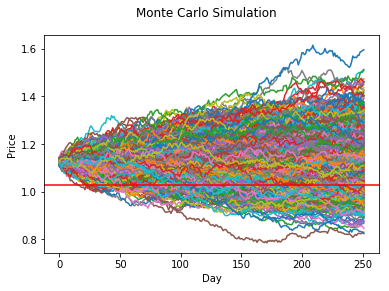

In [6]:
plotMC(eurusd, 1000)

We can do the same for gbpusd.

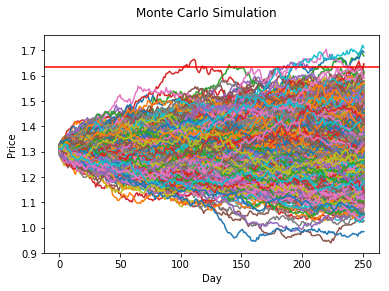

In [7]:
plotMC(gbpusd, 1000)

If we want to contain the results of simulations for eurusd and gbpusd, we can run multiMC(num_sims, eurusd, gbpusd) which returns a dataframe with the results of all simulations.

The 1st 252 columns contain the results of num_sims simulations for eurusd, and the final 252 columns contain the same for gbpusd.

In [8]:
multiMC(100, eurusd, gbpusd).head(10)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.144393,1.127327,1.121777,1.126728,1.126327,1.120206,1.131884,1.132133,1.126189,1.119531,...,1.118699,1.122149,1.113822,1.123748,1.136707,1.132361,1.129371,1.134469,1.130483,1.121980
1,1.147973,1.129251,1.118017,1.127871,1.131923,1.124042,1.128208,1.126819,1.120677,1.112440,...,1.120321,1.120020,1.110507,1.114015,1.132355,1.134249,1.118309,1.126162,1.134320,1.119180
2,1.145708,1.129624,1.134426,1.128246,1.126017,1.118547,1.135887,1.128584,1.123436,1.107991,...,1.115921,1.108119,1.100856,1.103646,1.128163,1.134528,1.111153,1.120604,1.136569,1.120726
3,1.143816,1.127378,1.121969,1.119698,1.130448,1.118571,1.135858,1.126699,1.117671,1.109353,...,1.119232,1.118242,1.100844,1.112106,1.123188,1.138630,1.115032,1.112047,1.118465,1.116669
4,1.155098,1.123146,1.125899,1.118940,1.140282,1.113999,1.133210,1.130391,1.121211,1.115864,...,1.118543,1.110319,1.091838,1.124286,1.126050,1.135388,1.127109,1.109587,1.123262,1.124216
5,1.153781,1.126180,1.132714,1.116516,1.137727,1.126564,1.130749,1.133560,1.130901,1.127923,...,1.116246,1.110673,1.088414,1.123940,1.121115,1.132459,1.134816,1.109521,1.125537,1.123791
6,1.164594,1.119111,1.130272,1.117634,1.137178,1.121663,1.132994,1.134162,1.146610,1.134261,...,1.123393,1.104151,1.090214,1.126864,1.126859,1.133293,1.149032,1.098638,1.131586,1.116800
7,1.177076,1.119806,1.122211,1.101129,1.151669,1.124511,1.119138,1.136803,1.148305,1.141196,...,1.121203,1.105011,1.084944,1.131177,1.117993,1.130249,1.161234,1.089914,1.138543,1.118719
8,1.184247,1.119238,1.126350,1.096872,1.156895,1.132731,1.126178,1.143556,1.155909,1.147577,...,1.130297,1.116265,1.094386,1.134503,1.119736,1.126944,1.171646,1.087893,1.145958,1.119921
9,1.181786,1.111943,1.130547,1.102794,1.145327,1.126253,1.133524,1.139097,1.154303,1.138150,...,1.126507,1.104326,1.094565,1.136273,1.119143,1.129484,1.171504,1.075606,1.149484,1.127447


Next we want to simulate the value of our portfolio over a time period. I have chosen 1 year.

The portfolioMC(portfolio, portfolio_init, eurusd, gbpusd, num_sims) function uses the results from multiMC to calculate the values of the EUR and GBP assets after 1 year. It does this by multiplying the asset values by their annual return, and the EUR and GBP assets are converted to the simulated price after 1 year.

The total value of the portfolio (in USD) is displayed in a list as below.

In [9]:
port_series = portfolioMC(portfolio, portfolio_init, eurusd, gbpusd, 100)
port_series[0:10]

[95.88177469081484,
 98.0403324124729,
 97.99556625688798,
 102.88311535052884,
 101.01844384227228,
 95.55846387726976,
 93.76239886604786,
 97.32549196937431,
 97.22756607704099,
 101.91658981088798]

Next we calculate the IRR at risk for the year. We do this by calculating the IRR in each scenario generated and taking the mean.

The formula for IRR is derived by setting the formula for NPV (Net Present Value) = 0.

NPV = sum(Cash_Flow/(1+r)^n = 0

Where Cash_Flow represents the cash flow for that period, r is the IRR and n is the time period.

For the case of 1 year, the equation simplifies as follows:

cash_flow + portfolio.return/(1+r) = 0

where: cash_flow = -100 (100Million USD)
     : portfolio.return = the simulated portfolio value
     : r = IRR
     
Solving for r (IRR): 

r = (portfolio.return / Fund.value) - 1



In [10]:
meanIRR(port_series, Fund1)

-0.017588739587093914

A negative IRR value indicates the sum of the post investment cashflows is less than the initial investment.

We can use the IRRMonteCarlo(num_sims, Fund, portfolio_init, portfolio, eurusd, gbpusd) function to run the entire process in one function.

Testing for 2000 simulations yields:

In [11]:
IRRMonteCarlo(2000, Fund1, portfolio_init, portfolio, eurusd, gbpusd)

-0.004911816221213379

This negative value suggests that the portfolio is likely to yield a negative return based on the model assumptions.

The model could be improved in the following ways:

1. Properly fit distributions with more accurate parameters based on historical data.
2. Investigate the behaviour of the random walks generated by the Monte Carlo simulations by comparing them to the behaviour of historical FOREX data.
3. Calculate IRR at risk over more periods than just 1 year.
4. Optimise the code by reducing the computational complexity of the functions. 
5. Use more class methods.
6. Use more of the market data provided and generate a hedging strategy using knock-in options.
7. Write some test cases for the code. (The only reason I didn't do this is because I debugged my code in spyder before creating the PyPI package).
